In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, roc_auc_score
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Preparation

In [2]:
# Add header=None as the first row of the file contains the names of the columns. 
# Add engine='python' to avoid parser warning raised for reading a file that doesn’t use the default ‘c’ parser.

income_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
                          header=None, delimiter=', ', engine='python')
income_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# Add headers to dataset
headers = ['age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship',
           'race','sex','capital_gain','capital_loss','hours_per_week','native_country','income']

income_data.columns = headers
income_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Data CLeaning

In [4]:
# Check for empty cells and if data types are correct for the respective columns
income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


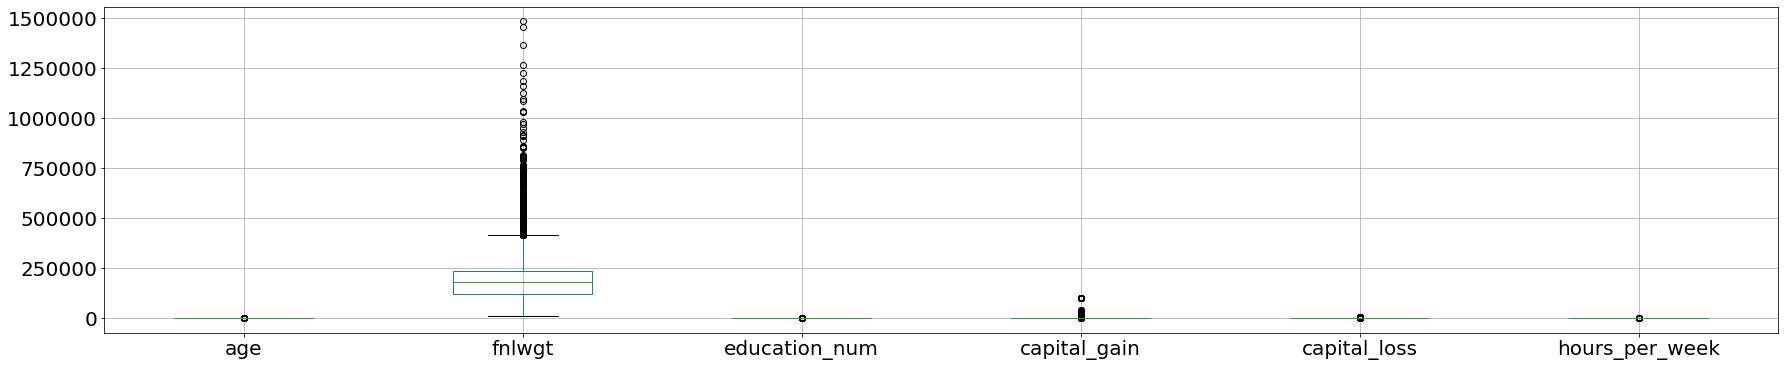

In [5]:
# Use a boxplot to detect any outliers
income_data.boxplot(figsize=(30,6), fontsize=20);

In [6]:
clean_df = income_data.drop(['fnlwgt'], axis=1)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   education       32561 non-null  object
 3   education_num   32561 non-null  int64 
 4   marital_status  32561 non-null  object
 5   occupation      32561 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital_gain    32561 non-null  int64 
 10  capital_loss    32561 non-null  int64 
 11  hours_per_week  32561 non-null  int64 
 12  native_country  32561 non-null  object
 13  income          32561 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


In [7]:
# Select duplicate rows except first occurrence based on all columns
dup_rows = clean_df[clean_df.duplicated()]
dup_rows

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
352,33,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
391,27,Private,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,50,United-States,<=50K
563,24,Private,HS-grad,9,Never-married,Handlers-cleaners,Unmarried,Black,Female,0,0,40,United-States,<=50K
570,24,Private,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
673,33,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32503,47,Private,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
32512,20,Private,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,40,United-States,<=50K
32527,22,Private,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,40,United-States,<=50K
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K


## Label Encoding

In [8]:
# Categorical boolean mask
categorical_feature_mask = clean_df.dtypes==object

# Filter categorical columns using mask and turn it into a list
categorical_cols = clean_df.columns[categorical_feature_mask].tolist()

In [9]:
# Instantiate labelencoder object
le = LabelEncoder()

# Apply label encoder on categorical feature columns
clean_df[categorical_cols] = clean_df[categorical_cols].apply(lambda col: le.fit_transform(col))
clean_df[categorical_cols].head(5)

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,7,9,4,1,1,4,1,39,0
1,6,9,2,4,0,4,1,39,0
2,4,11,0,6,1,4,1,39,0
3,4,1,2,6,0,2,1,39,0
4,4,9,2,10,5,2,0,5,0


In [10]:
X = clean_df.iloc[:,0:13]  # independent columns - features
y = clean_df.iloc[:,-1]    # target column - income

In [11]:
# Distribution of target variable
print(clean_df["income"].value_counts())

0    24720
1     7841
Name: income, dtype: int64


In [12]:
print(clean_df["income"].value_counts(normalize=True))
# 0 for label: <= U$50K
# 1 for label: > U$50K

0    0.75919
1    0.24081
Name: income, dtype: float64


In [13]:
X_train_bopt, X_test_bopt, y_train_bopt, y_test_bopt = train_test_split(X, y,
                                                                        test_size = 0.3,
                                                                        random_state = 1)

In [14]:
# Perform pre-processing to scale numeric features
scale = preprocessing.StandardScaler()
X_train_bopt = scale.fit_transform(X_train_bopt)

# Test features are scaled using the scaler computed for the training features
X_test_bopt = scale.transform(X_test_bopt)

## Data Modelling

## Model 1: Decision Tree

In [15]:
# Create decision tree classifier
tree = DecisionTreeClassifier(random_state=1)

In [16]:
# Fit training data and training labels to decision tree
tree.fit(X_train_bopt, y_train_bopt)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [17]:
print(f'Decision Tree has {tree.tree_.node_count} nodes with a maximum depth of {tree.tree_.max_depth}.')

Decision Tree has 8521 nodes with a maximum depth of 37.


In [18]:
print(f'Model Accuracy for train data: {tree.score(X_train_bopt, y_train_bopt)}')
print(f'Model Accuracy for test data: {tree.score(X_test_bopt, y_test_bopt)}')

Model Accuracy for train data: 0.9794664794664795
Model Accuracy for test data: 0.8240352134302386


### Visualization of the Decision Tree

In [19]:
# Create and fit decision tree with maximum depth 3
tree = DecisionTreeClassifier(max_depth=3, random_state=1)
tree.fit(X_train_bopt, y_train_bopt)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

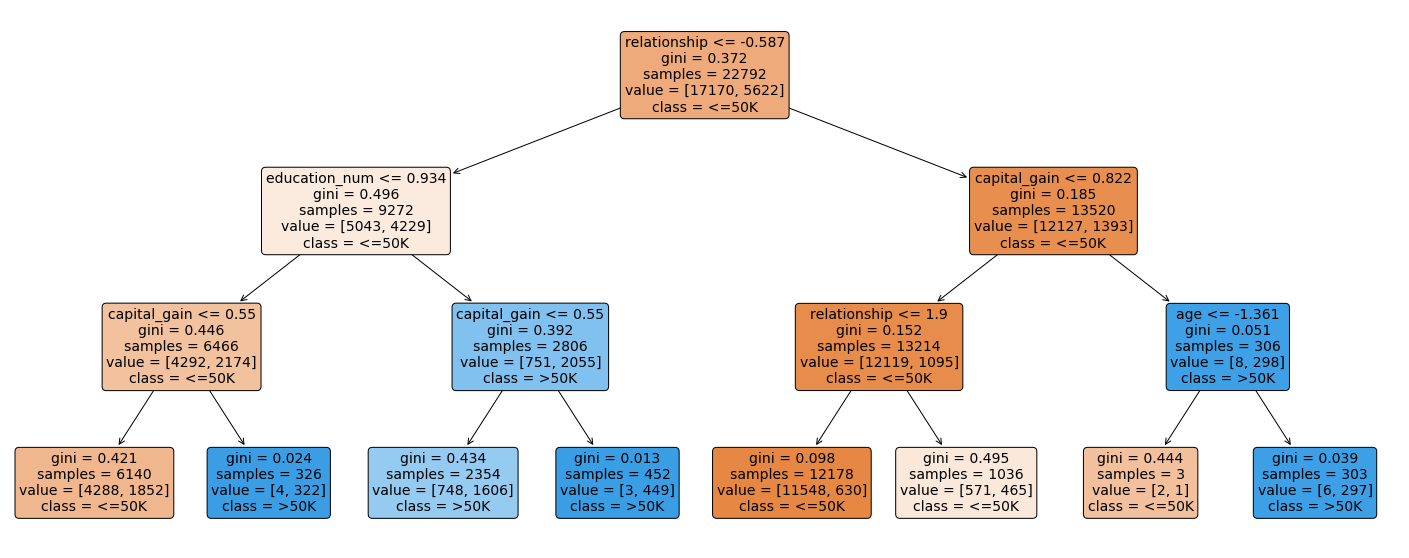

In [20]:
# Plot the decision tree
plt.figure(figsize=(25,10))
decision_tree_plot = plot_tree(tree, feature_names=X.columns, 
                               class_names=['<=50K','>50K'], 
                               filled=True, rounded=True, fontsize=14)

### Pruning the Decision Tree

In [21]:
# Create for loop to prune tree
scores = []

for i in range(1, 31):
    tree = DecisionTreeClassifier(random_state=1, max_depth=i)
    tree.fit(X_train_bopt, y_train_bopt)
    score = tree.score(X_test_bopt, y_test_bopt)
    scores.append(tree.score(X_test_bopt, y_test_bopt))

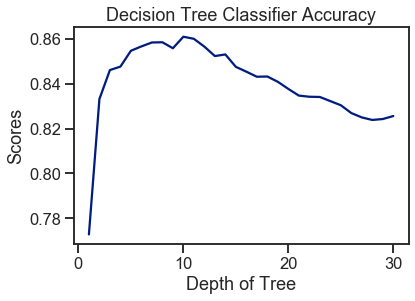

In [22]:
# Plot graph to see how individual accuracy scores changes with tree depth
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('ticks')

plt.plot(range(1, 31), scores)
plt.xlabel("Depth of Tree")
plt.ylabel("Scores")
plt.title("Decision Tree Classifier Accuracy")
plt.show()

## Model 2: Random Forest

### Out-of-Bag Error Evaluation

In [23]:
# Initialise the random forest estimator
# Set 'warm_start=true' so that more trees are added to the 
# existing model each iteration
RF = RandomForestClassifier(oob_score=True, random_state=1, 
                            warm_start=True, n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for the number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    RF.set_params(n_estimators=n_trees)  # Set number of trees
    RF.fit(X_train_bopt, y_train_bopt)
    oob_error = 1 - RF.oob_score_ # Obtain the oob error
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

C:\Users\ACER\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\ACER\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\ACER\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\ACER\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


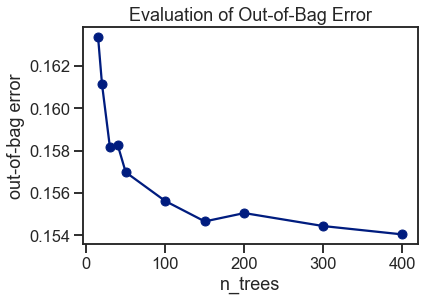

In [24]:
ax = rf_oob_df.plot(legend=False, marker='o')
ax.set(ylabel='out-of-bag error',
      title='Evaluation of Out-of-Bag Error');

In [25]:
# Create the model with 150 trees
forest = RandomForestClassifier(n_estimators=150, random_state=1, n_jobs=-1)

In [26]:
# Fit training data and training labels to forest
forest.fit(X_train_bopt, y_train_bopt)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [27]:
n_nodes = []
max_depths = []

for ind_tree in forest.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Random Forest has an average number of nodes {int(np.mean(n_nodes))} with an average maximum depth of {int(np.mean(max_depths))}.')

Random Forest has an average number of nodes 7195 with an average maximum depth of 40.


In [28]:
print(f'Model Accuracy for train data: {forest.score(X_train_bopt, y_train_bopt)}')
print(f'Model Accuracy for test data: {forest.score(X_test_bopt, y_test_bopt)}')

Model Accuracy for train data: 0.9794664794664795
Model Accuracy for test data: 0.8563824342307299


## Feature Importance

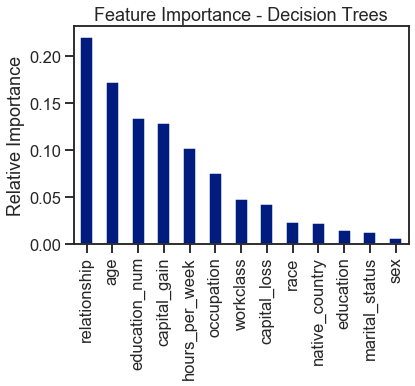

In [29]:
feature_imp = pd.Series(tree.feature_importances_, 
                        index=X.columns).sort_values(ascending=False)

ax = feature_imp.plot(kind='bar')
ax.set(title='Feature Importance - Decision Trees',
       ylabel='Relative Importance');

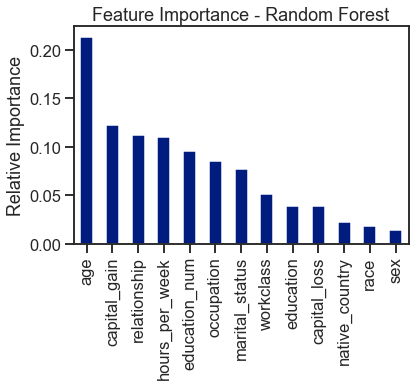

In [30]:
feature_imp = pd.Series(forest.feature_importances_, 
                        index=X.columns).sort_values(ascending=False)

ax = feature_imp.plot(kind='bar')
ax.set(title='Feature Importance - Random Forest',
       ylabel='Relative Importance');

## Feature Selection using 2 Methods:

### 1. Univariate Selection

In [31]:
# Apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Concatenate two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  # naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  # print 10 best features

          Features         Score
9     capital_gain  8.219247e+07
10    capital_loss  1.372146e+06
0              age  8.600612e+03
11  hours_per_week  6.476409e+03
6     relationship  3.659143e+03
3    education_num  2.401422e+03
4   marital_status  1.123470e+03
5       occupation  5.045589e+02
8              sex  5.024394e+02
2        education  2.979423e+02


### 2. Correlation Matrix with Heatmap

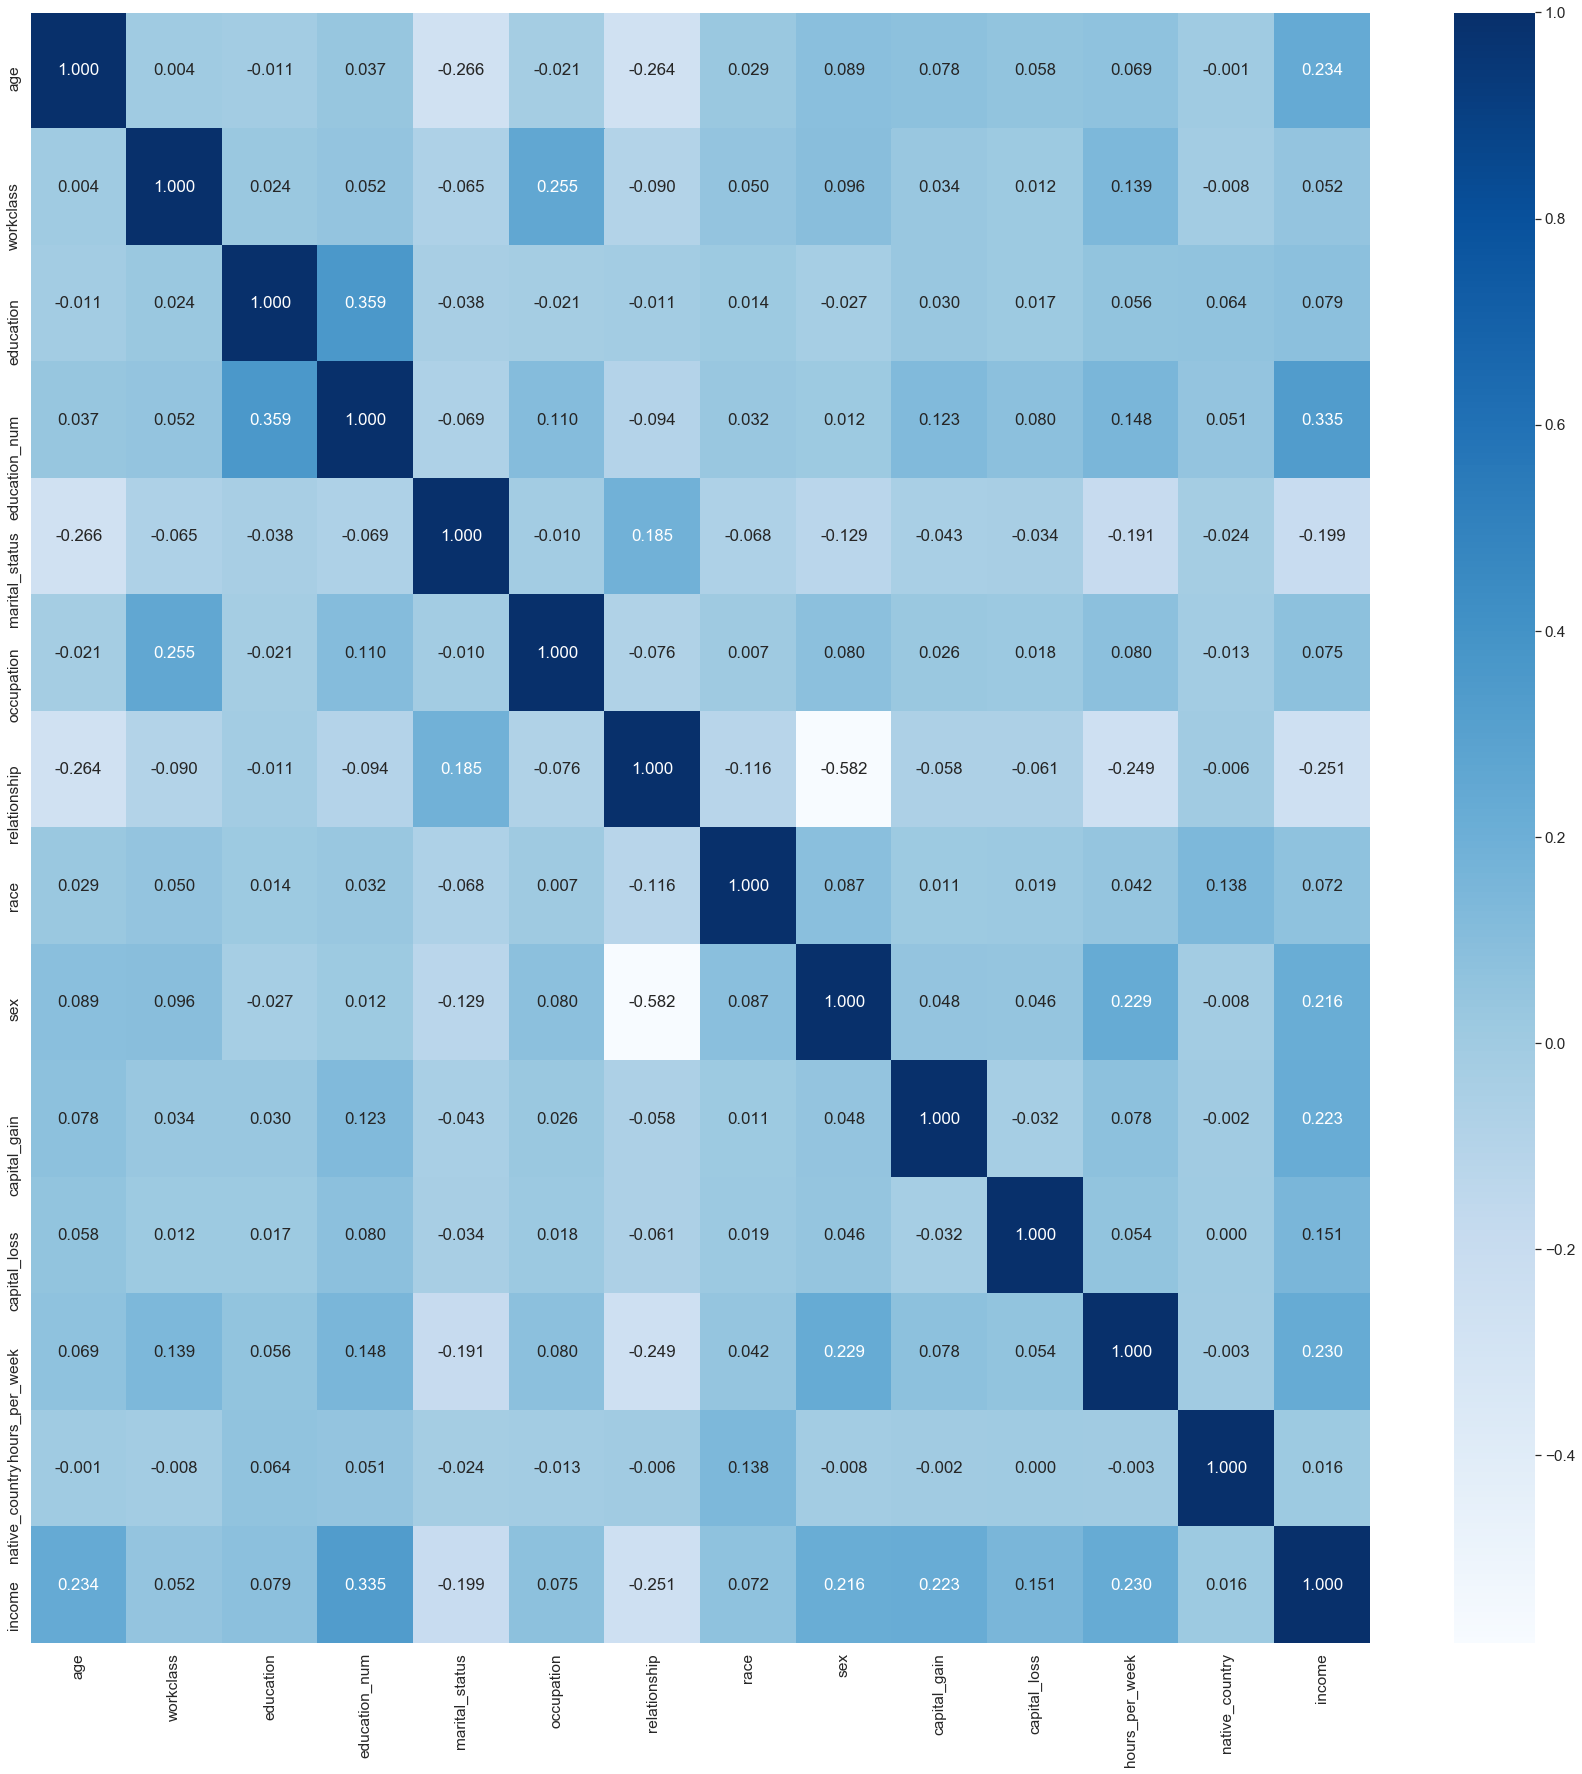

In [32]:
# Obtain correlations of each features in dataset
sns.set(font_scale=1.4)
corrmat = clean_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(30,30))

# Plot heat map
correlation = sns.heatmap(clean_df[top_corr_features].corr(),annot=True,fmt=".3f",cmap='Blues')

In [33]:
# Select top 4 features based on the above feature selection methods 
features = clean_df[['capital_gain','education_num','hours_per_week','age']]
feature_cols = features.columns

### Upsampling

In [37]:
# Separate majority and minority classes
df_majority = clean_df[clean_df.income==0]
df_minority = clean_df[clean_df.income==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=24720,  # to match majority class
                                 random_state=1)   # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [38]:
# Display new class counts
df_upsampled.income.value_counts()

1    24720
0    24720
Name: income, dtype: int64

In [39]:
df_upsampled.income.value_counts(normalize=True)

1    0.5
0    0.5
Name: income, dtype: float64

In [40]:
X_upsamp = df_upsampled[feature_cols]
y_upsamp = df_upsampled['income']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_upsamp, y_upsamp, 
                                                    test_size = 0.3, 
                                                    random_state = 1)

In [42]:
# Perform pre-processing to scale numeric features
scale = preprocessing.StandardScaler()
X_train = scale.fit_transform(X_train)

# Test features are scaled using the scaler computed for the training features
X_test = scale.transform(X_test)

### Random Forest Optimization through Grid Search

In [43]:
# Set the model parameters for grid search
model_params = {
    'n_estimators': [150, 200, 250, 300],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 4, 6]
}

In [44]:
# Create random forest classifier model
rf_model = RandomForestClassifier(random_state=1)

# Set up grid search meta-estimator
gs = GridSearchCV(rf_model, model_params,n_jobs=-1, scoring='roc_auc', cv=3)

# Train the grid search meta-estimator to find the best model
best_model = gs.fit(X_train, y_train)

# Print best set of hyperparameters
from pprint import pprint
pprint(best_model.best_estimator_.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


### Use Best Model from Optimization for Random Forest

In [45]:
n_nodes = []
max_depths = []

for ind_tree in best_model.best_estimator_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'The optimized random forest has an average number of nodes {int(np.mean(n_nodes))} with an average maximum depth of {int(np.mean(max_depths))}.')

The optimized random forest has an average number of nodes 4579 with an average maximum depth of 20.


In [46]:
print(f'Model Accuracy for train data: {best_model.score(X_train, y_train)}')
print(f'Model Accuracy for test data: {best_model.score(X_test, y_test)}')

Model Accuracy for train data: 0.9281771182037113
Model Accuracy for test data: 0.887632282041068


## Performance Evaluation of Models

In [47]:
# Predict target variables (ie. labels) for each classifer
dt_classifier_name = ["Decision Tree"]
dt_predicted_labels = tree.predict(X_test_bopt)

rf_classifier_name = ["Random Forest"]
rf_predicted_labels = forest.predict(X_test_bopt)

best_model_classifier_name = ["Optimized Random Forest"]
best_model_predicted_labels = best_model.predict(X_test)

### 1. Classification Report

In [49]:
print("Classification Report for",dt_classifier_name, " :\n ",
      metrics.classification_report(y_test_bopt, dt_predicted_labels, 
                                    target_names=['Income <= U$50K','Income > U$50K']))

Classification Report for ['Decision Tree']  :
                   precision    recall  f1-score   support

Income <= U$50K       0.89      0.89      0.89      7550
 Income > U$50K       0.62      0.62      0.62      2219

       accuracy                           0.83      9769
      macro avg       0.75      0.75      0.75      9769
   weighted avg       0.83      0.83      0.83      9769



In [50]:
print("Classification Report for ",rf_classifier_name, " :\n ",
      metrics.classification_report(y_test_bopt, rf_predicted_labels,
                                   target_names=['Income <= U$50K','Income > U$50K']))

Classification Report for  ['Random Forest']  :
                   precision    recall  f1-score   support

Income <= U$50K       0.90      0.92      0.91      7550
 Income > U$50K       0.70      0.63      0.67      2219

       accuracy                           0.86      9769
      macro avg       0.80      0.78      0.79      9769
   weighted avg       0.85      0.86      0.85      9769



In [51]:
print("Classification Report for ",best_model_classifier_name, " :\n ",
      metrics.classification_report(y_test,best_model_predicted_labels,
                                   target_names=['Income <= U$50K','Income > U$50K']))

Classification Report for  ['Optimized Random Forest']  :
                   precision    recall  f1-score   support

Income <= U$50K       0.83      0.75      0.79      7516
 Income > U$50K       0.77      0.84      0.80      7316

       accuracy                           0.79     14832
      macro avg       0.80      0.79      0.79     14832
   weighted avg       0.80      0.79      0.79     14832



### 2. Confusion Matrix

Confusion Matrix for ['Decision Tree']


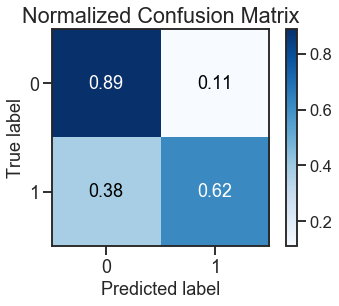

In [91]:
print("Confusion Matrix for",dt_classifier_name)
skplt.metrics.plot_confusion_matrix(y_test_bopt, dt_predicted_labels, normalize=True)                                
plt.show()

Confusion Matrix for ['Random Forest']


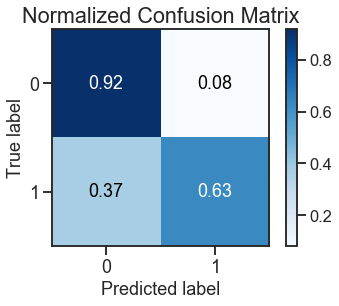

In [61]:
print("Confusion Matrix for",rf_classifier_name)
skplt.metrics.plot_confusion_matrix(y_test_bopt, rf_predicted_labels, normalize=True)
plt.show()

Confusion Matrix for ['Optimized Random Forest']


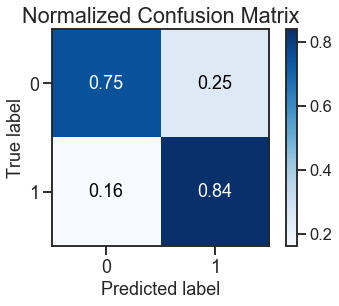

In [50]:
print("Confusion Matrix for",best_model_classifier_name)
skplt.metrics.plot_confusion_matrix(y_test, best_model_predicted_labels, normalize=True)
plt.show()

### 3. Precision-Recall Curve

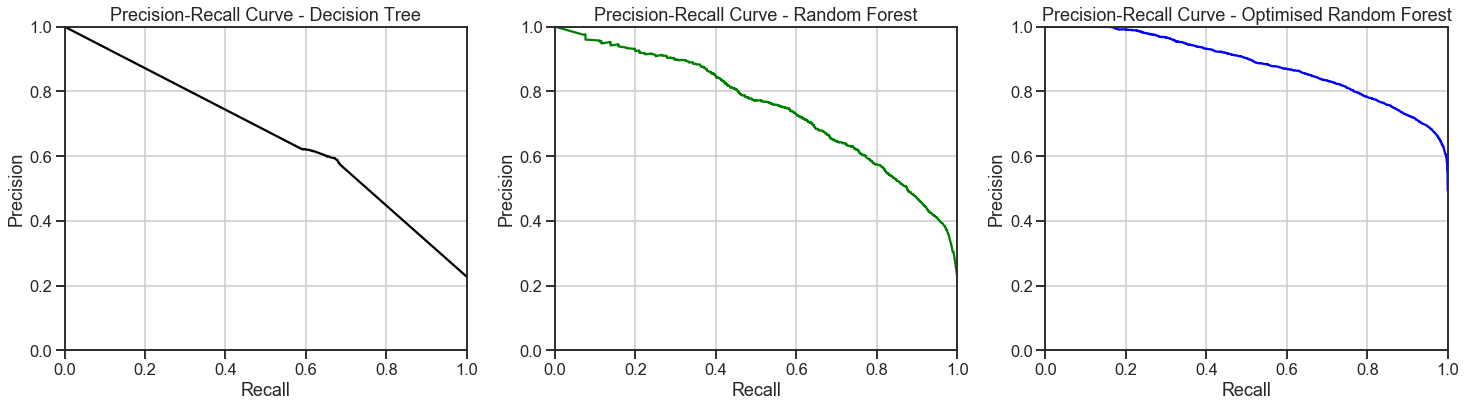

In [51]:
fig, axList = plt.subplots(ncols=3)
fig.set_size_inches(21,6)

# Plot the Precision-Recall curve for Decision Tree   
ax = axList[0]
dt_predicted_proba = tree.predict_proba(X_test_bopt)
precision, recall, _ = precision_recall_curve(y_test_bopt, dt_predicted_proba[:,1])
ax.plot(recall, precision,color='black')
ax.set(xlabel='Recall', ylabel='Precision', xlim=[0, 1], ylim=[0, 1],
       title='Precision-Recall Curve - Decision Tree')
ax.grid(True)

# Plot the Precision-Recall curve for Random Forest
ax = axList[1]
rf_predicted_proba = forest.predict_proba(X_test_bopt)
precision, recall, _ = precision_recall_curve(y_test_bopt, rf_predicted_proba[:,1])
ax.plot(recall, precision,color='green')
ax.set(xlabel='Recall', ylabel='Precision', xlim=[0, 1], ylim=[0, 1],
       title='Precision-Recall Curve - Random Forest')
ax.grid(True)

# Plot the Precision-Recall curve for Optimized Random Forest
ax = axList[2]
best_model_predicted_proba = best_model.predict_proba(X_test)
precision, recall, _ = precision_recall_curve(y_test, best_model_predicted_proba[:,1])
ax.plot(recall, precision,color='blue')
ax.set(xlabel='Recall', ylabel='Precision', xlim=[0, 1], ylim=[0, 1],
       title='Precision-Recall Curve - Optimised Random Forest')
ax.grid(True)
plt.tight_layout()

### 4. ROC Curve and AUC

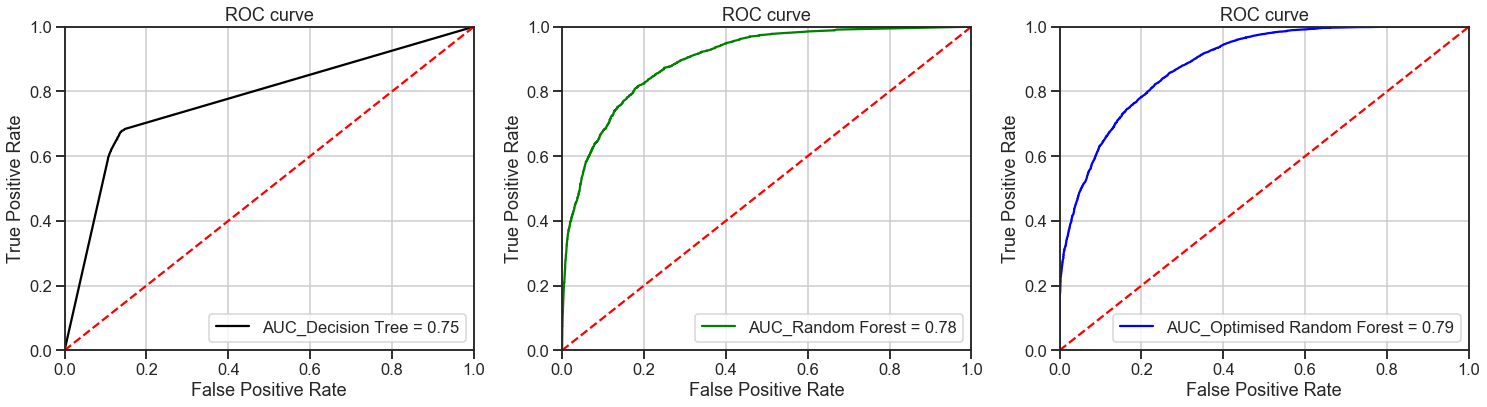

In [52]:
fig, axList = plt.subplots(ncols=3)
fig.set_size_inches(21,6)

# Plot the ROC-AUC curve for Decision Tree
ax = axList[0]
dt = tree.fit(X_train_bopt, y_train_bopt.values.ravel()) 
dt_predicted_label_r = dt.predict_proba(X_test_bopt)

def plot_auc(y, probs):
    fpr, tpr, threshold = roc_curve(y, probs[:,1])
    auc = roc_auc_score(y_test_bopt, dt_predicted_labels)
    ax.plot(fpr, tpr, color = 'black', label = 'AUC_Decision Tree = %0.2f' % auc)
    ax.plot([0, 1], [0, 1],'r--')
    ax.legend(loc = 'lower right')
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[0, 1], ylim=[0, 1],
           title='ROC curve')       
    
plot_auc(y_test_bopt, dt_predicted_label_r)
ax.grid(True)

# Plot the ROC-AUC curve for Random Forest
ax = axList[1]
rf = forest.fit(X_train_bopt, y_train_bopt.values.ravel()) 
rf_predicted_label_r = rf.predict_proba(X_test_bopt)

def plot_auc(y, probs):
    fpr, tpr, threshold = roc_curve(y, probs[:,1])
    auc = roc_auc_score(y_test_bopt, rf_predicted_labels)
    ax.plot(fpr, tpr, color = 'green', label = 'AUC_Random Forest = %0.2f' % auc)
    ax.plot([0, 1], [0, 1],'r--')
    ax.legend(loc = 'lower right')
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[0, 1], ylim=[0, 1],
           title='ROC curve') 
    
plot_auc(y_test_bopt, rf_predicted_label_r);
ax.grid(True)

# Plot the ROC-AUC curve for Optimized Random Forest
ax = axList[2]
best_model = best_model.fit(X_train, y_train.values.ravel()) 
best_model_predicted_label_r = best_model.predict_proba(X_test)

def plot_auc(y, probs):
    fpr, tpr, threshold = roc_curve(y, probs[:,1])
    auc = roc_auc_score(y_test, best_model_predicted_labels)
    ax.plot(fpr, tpr, color = 'blue', label = 'AUC_Optimised Random Forest = %0.2f' % auc)
    ax.plot([0, 1], [0, 1],'r--')
    ax.legend(loc = 'lower right')
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[0, 1], ylim=[0, 1],
           title='ROC curve') 
    
plot_auc(y_test, best_model_predicted_label_r);
ax.grid(True)
plt.tight_layout()

### 5. Calibration Curve 

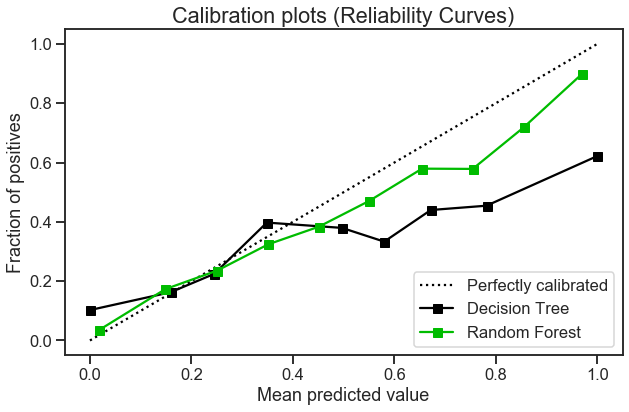

In [53]:
# Plot calibration curves for a set of classifier probability estimates.
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()

tree_probas = tree.fit(X_train_bopt, y_train_bopt).predict_proba(X_test_bopt)
forest_probas = forest.fit(X_train_bopt, y_train_bopt).predict_proba(X_test_bopt)

probas_list = [tree_probas, forest_probas]
clf_names = ['Decision Tree','Random Forest']

skplt.metrics.plot_calibration_curve(y_test_bopt, probas_list, clf_names,figsize=(10,6))
plt.show()

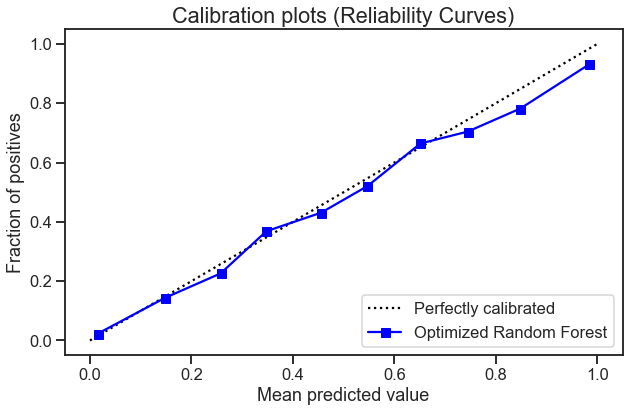

In [54]:
# Plot calibration curves for a set of classifier probability estimates.
best_model = RandomForestClassifier()

best_model_probas = best_model.fit(X_train, y_train).predict_proba(X_test)

probas_list = [best_model_probas]
clf_names = ['Optimized Random Forest']

skplt.metrics.plot_calibration_curve(y_test, probas_list, clf_names, cmap='winter', figsize=(10,6))
plt.show()